In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from ngboost import NGBRegressor
from ngboost.distns import MultivariateNormal
from sklearn.tree import DecisionTreeRegressor

from src.probabilistic_flow_boosting.independent_multivariate_boosting import IndependentNGBoost
from src.probabilistic_flow_boosting.pipelines.reporting.nodes import calculate_nll, calculate_nll_ngboost

In [2]:
x_train = catalog.load("momogp_parkinsons.x_train")
y_train = catalog.load("momogp_parkinsons.y_train")

x_test = catalog.load("momogp_parkinsons.x_test")
y_test = catalog.load("momogp_parkinsons.y_test")

treeflow = catalog.load("momogp_parkinsons.model")

2022-05-18 19:32:36,455 - kedro.io.data_catalog - INFO - Loading data from `momogp_parkinsons.x_train` (CSVDataSet)...
2022-05-18 19:32:36,466 - kedro.io.data_catalog - INFO - Loading data from `momogp_parkinsons.y_train` (CSVDataSet)...
2022-05-18 19:32:36,468 - kedro.io.data_catalog - INFO - Loading data from `momogp_parkinsons.x_test` (CSVDataSet)...
2022-05-18 19:32:36,472 - kedro.io.data_catalog - INFO - Loading data from `momogp_parkinsons.y_test` (CSVDataSet)...
2022-05-18 19:32:36,474 - kedro.io.data_catalog - INFO - Loading data from `momogp_parkinsons.model` (TFBoostDataSet)...


In [3]:
ngb = NGBRegressor(
    Dist=MultivariateNormal(y_train.shape[1]),
    Base=DecisionTreeRegressor(
        random_state=42,
        **{'max_depth': 15, 'min_samples_leaf': 32, 'max_leaf_nodes': 64}
    ),
    n_estimators=500
)

ngb_indep = IndependentNGBoost(
    params_tree = {
        'max_depth': 10, 
        'min_samples_leaf': 32, 
        'max_leaf_nodes': 32,
        'random_state': 42
    }, 
    params_ngboost = {"n_estimators": 300}
)

In [4]:
ngb.fit(x_train.values, y_train.values)

[iter 0] loss=6.1630 val_loss=0.0000 scale=0.2500 norm=2.8288
[iter 100] loss=5.8967 val_loss=0.0000 scale=0.2500 norm=2.6142
[iter 200] loss=5.7623 val_loss=0.0000 scale=0.2500 norm=2.4567
[iter 300] loss=5.6482 val_loss=0.0000 scale=0.2500 norm=2.3233
[iter 400] loss=5.5468 val_loss=0.0000 scale=0.2500 norm=2.2105


NGBRegressor(Base=DecisionTreeRegressor(max_depth=15, max_leaf_nodes=64,
                                        min_samples_leaf=32, random_state=42),
             Dist=<class 'ngboost.distns.multivariate_normal.MultivariateNormal.<locals>.MVN'>,
             random_state=RandomState(MT19937) at 0x7F75FD3ECCA8)

In [5]:
ngb_indep.fit(x_train.values, y_train.values, None, None)

[iter 0] loss=3.5052 val_loss=0.0000 scale=1.0000 norm=6.9297
[iter 100] loss=3.3062 val_loss=0.0000 scale=1.0000 norm=5.7594
[iter 200] loss=3.1797 val_loss=0.0000 scale=1.0000 norm=5.1489
[iter 0] loss=3.7846 val_loss=0.0000 scale=1.0000 norm=8.6425
[iter 100] loss=3.5621 val_loss=0.0000 scale=1.0000 norm=7.3030
[iter 200] loss=3.4310 val_loss=0.0000 scale=1.0000 norm=6.5417


In [6]:
print(f"Train NLL NGB: {calculate_nll_ngboost(ngb, x_train, y_train, independent=False)}")
print(f"Test NLL NGB: {calculate_nll_ngboost(ngb, x_test, y_test, independent=False)}")

print(f"Train NLL Independent NGB: {calculate_nll_ngboost(ngb_indep, x_train, y_train, independent=True)}")
print(f"Test NLL Independent NGB: {calculate_nll_ngboost(ngb_indep, x_test, y_test, independent=True)}")

print(f"Train NLL TreeFlow: {calculate_nll(treeflow, x_train, y_train, batch_size=512)}")
print(f"Test NLL TreeFlow: {calculate_nll(treeflow, x_test, y_test, batch_size=512)}")

Train NLL NGB: 5.4441655426445665
Test NLL NGB: 5.850751857978128
Train NLL Independent NGB: 6.422337999458284
Test NLL Independent NGB: 6.861354051239283
Train NLL TreeFlow: 5.26513671875
Test NLL TreeFlow: 5.476717472076416


20


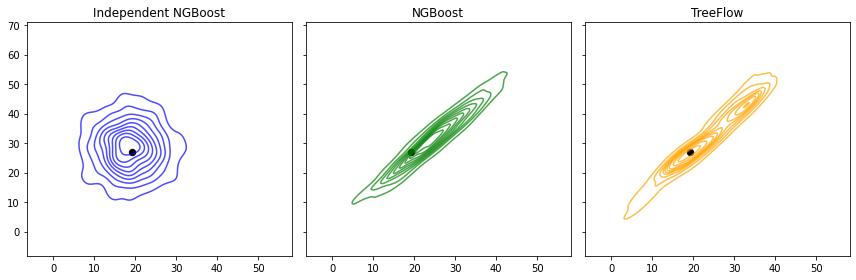

21


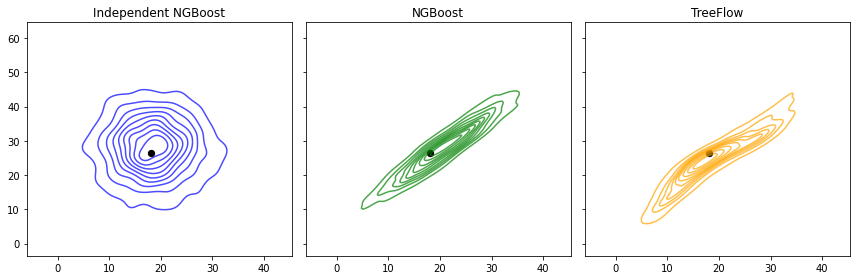

22


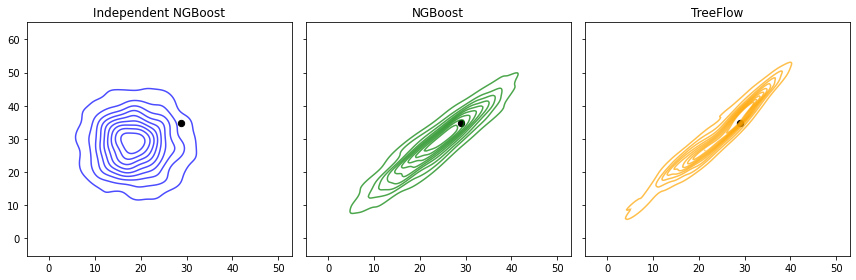

23


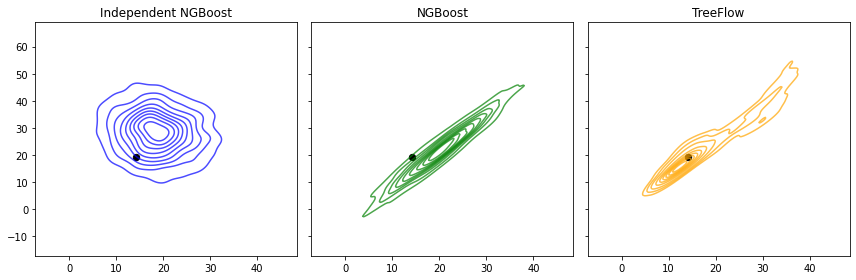

24


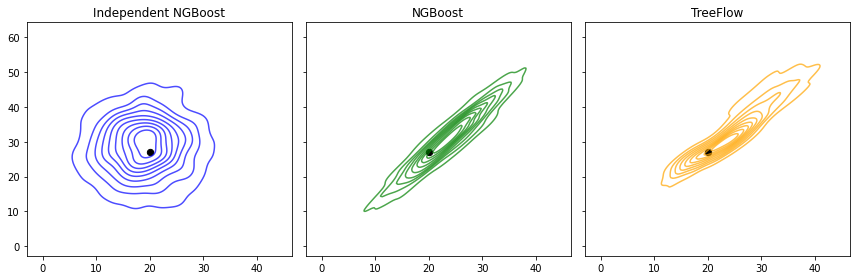

25


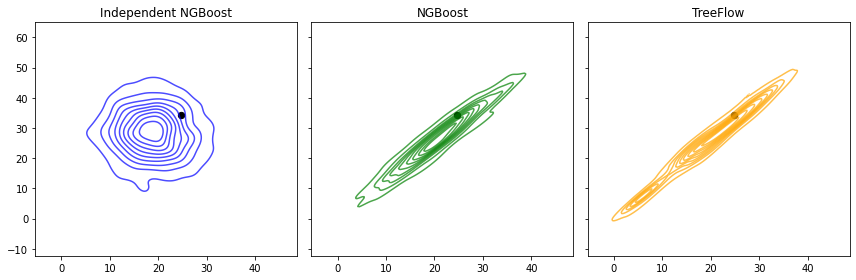

26


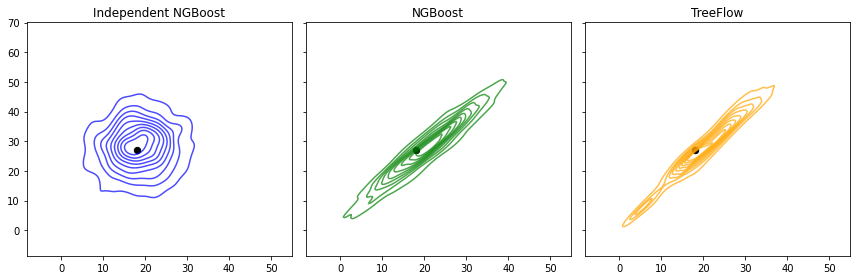

27


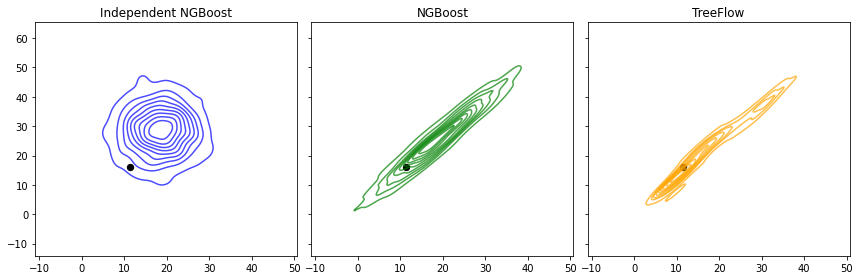

28


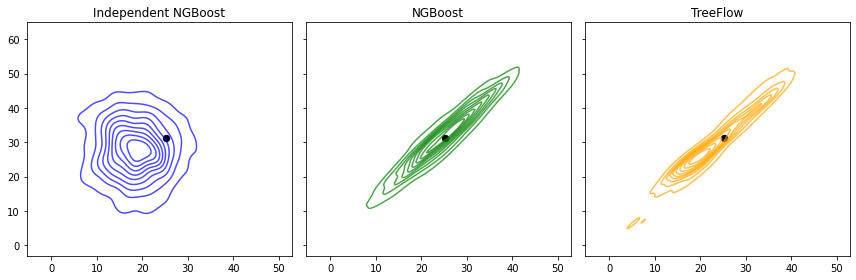

29


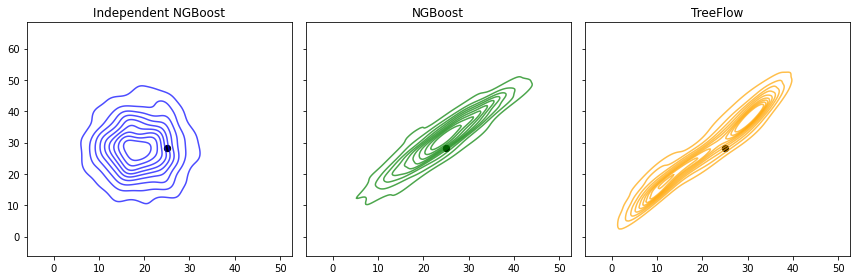

30


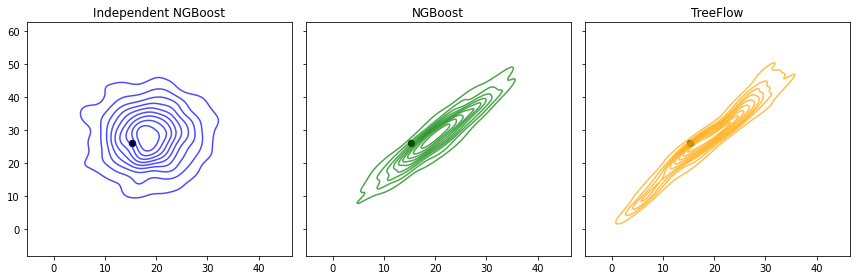

31


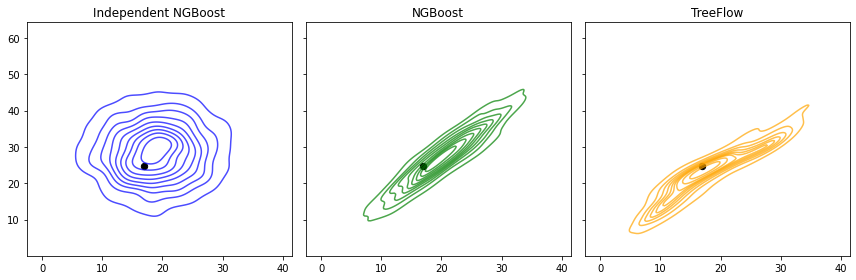

32


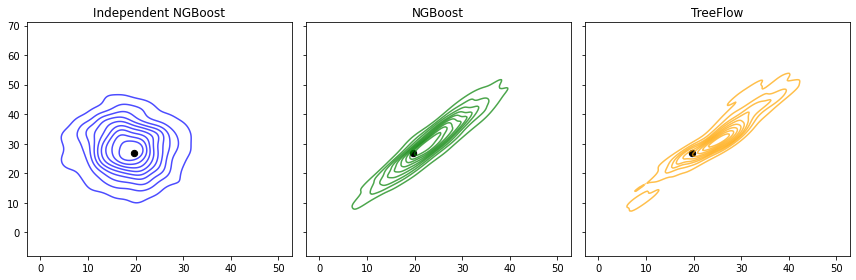

33


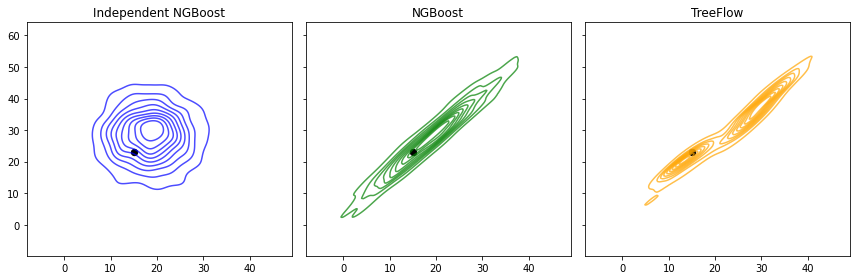

34


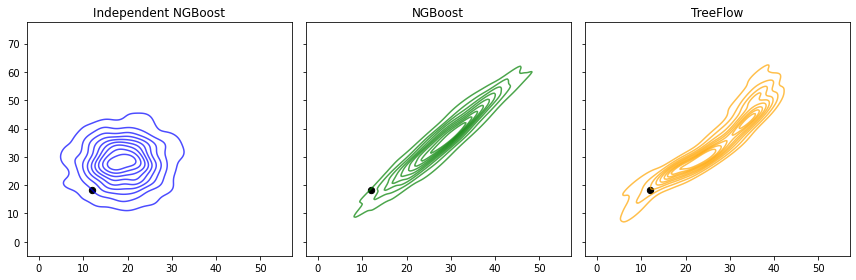

35


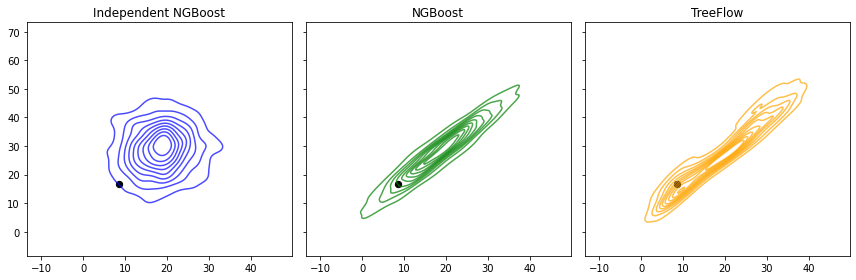

36


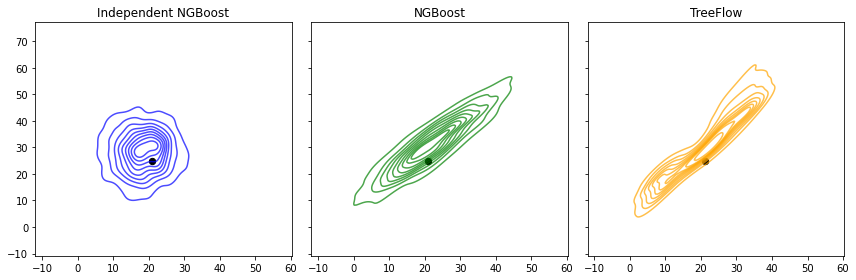

37


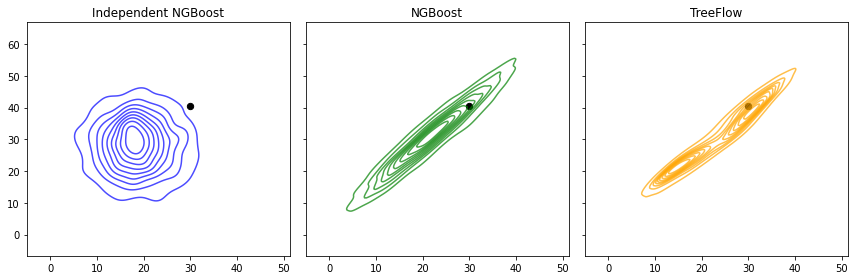

38


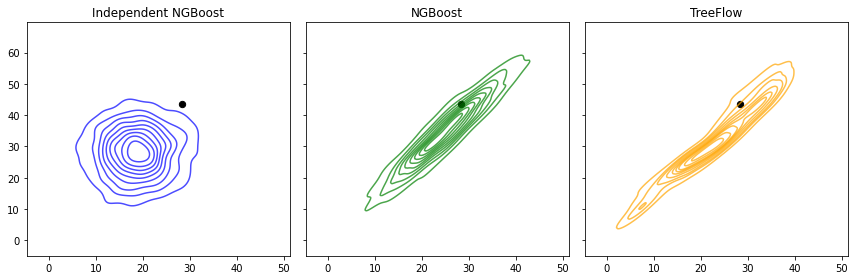

39


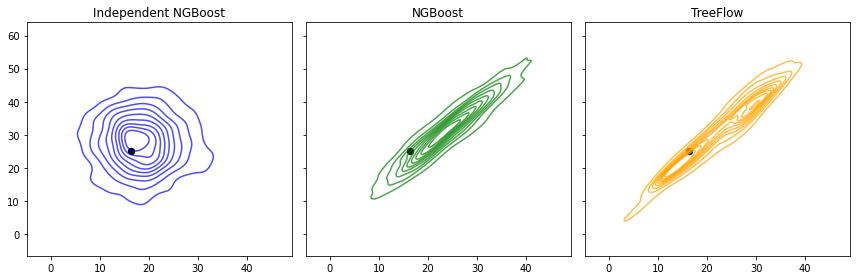

40


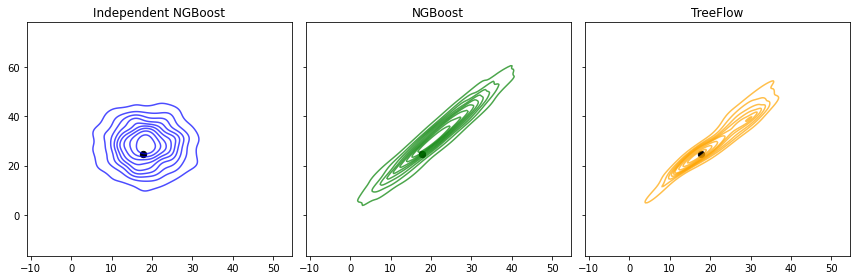

41


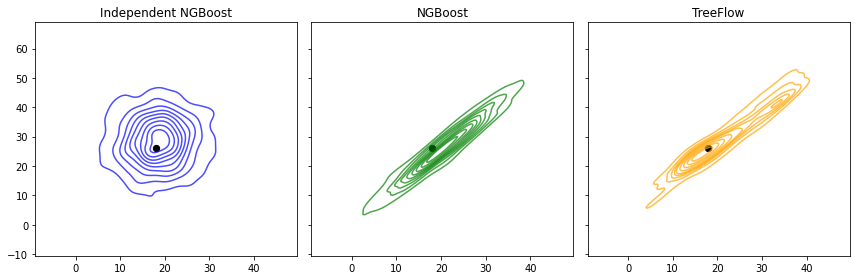

42


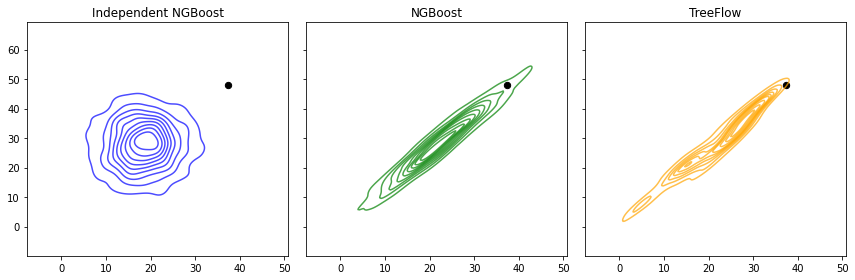

43


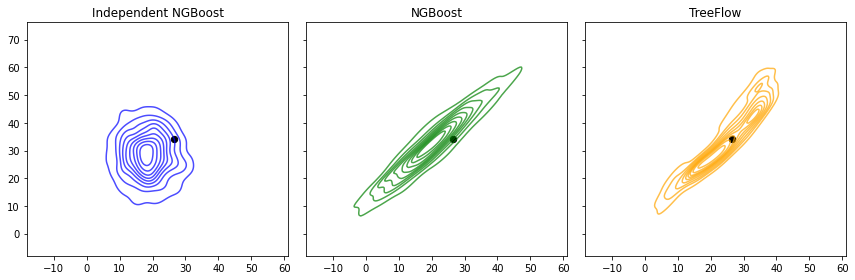

44


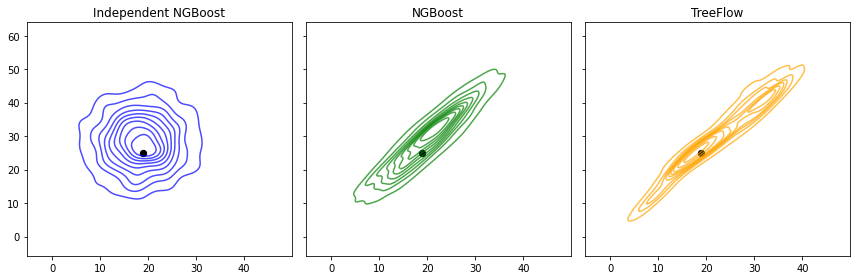

45


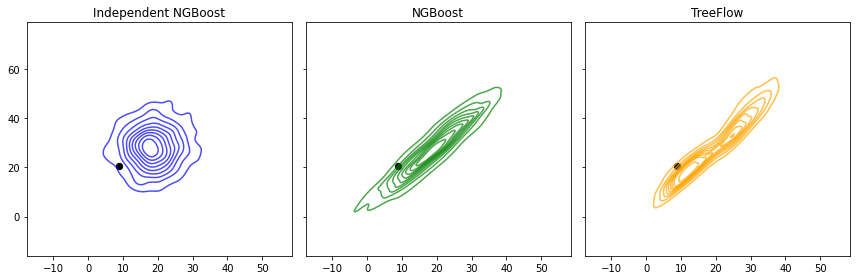

46


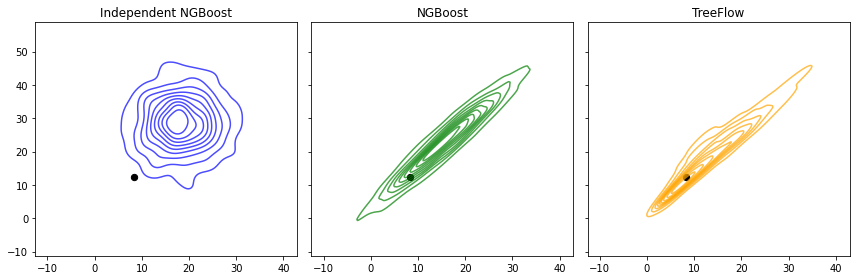

47


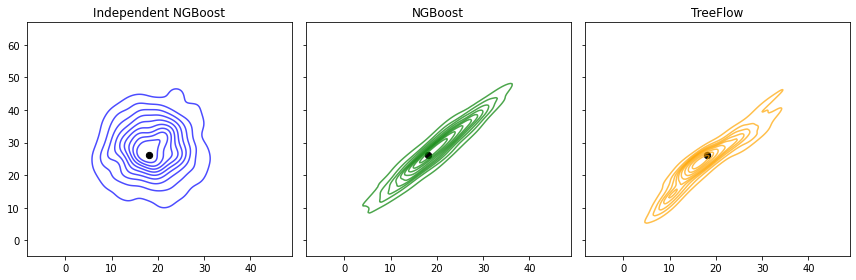

48


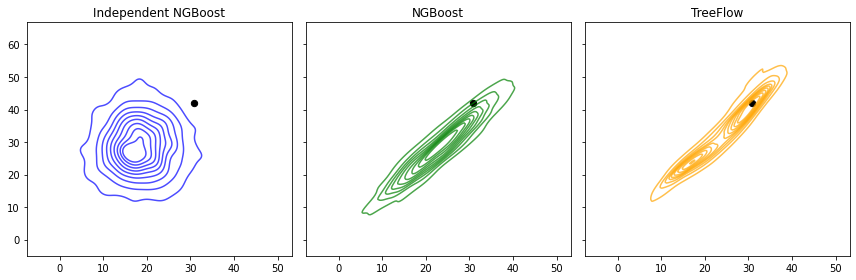

49


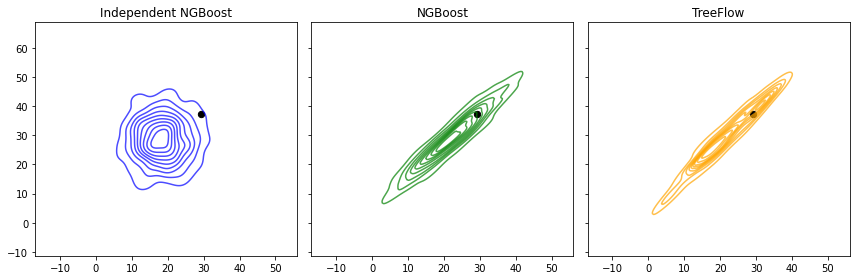

In [7]:
for i in range(20, 50):
    print(i)
    samples_tfb = treeflow.sample(x_test.values[i:i+1, :], num_samples=1000)
    samples_ngb = np.vstack(ngb.pred_dist(x_test.values[i:i+1, :]).sample(1000))
    samples_ngb_indep = ngb_indep.scipy_distribution(x_test.values[0:1, :])[0].rvs(1000)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True)
    
    sns.kdeplot(x=samples_ngb_indep[:, 0], y=samples_ngb_indep[:, 1], alpha = 0.7, color = 'blue', label = 'Independent NGBoost', ax=ax[0])
    ax[0].scatter(y_test.values[i, 0], y_test.values[i, 1], color = 'black', s = 40)
    ax[0].set_title('Independent NGBoost')
    
    sns.kdeplot(x=samples_ngb[:, 0], y=samples_ngb[:, 1], alpha = 0.7, color = 'green', label = 'NGBoost', ax=ax[1])
    ax[1].scatter(y_test.values[i, 0], y_test.values[i, 1], color = 'black', s = 40)
    ax[1].set_title('NGBoost')
    
    sns.kdeplot(x=samples_tfb[0, :, 0], y=samples_tfb[0, :, 1], alpha = 0.7, color = 'orange', label = 'TreeFlow', ax=ax[2])
    ax[2].scatter(y_test.values[i, 0], y_test.values[i, 1], color = 'black', s = 40)
    ax[2].set_title('TreeFlow')

    plt.tight_layout()
    plt.show()

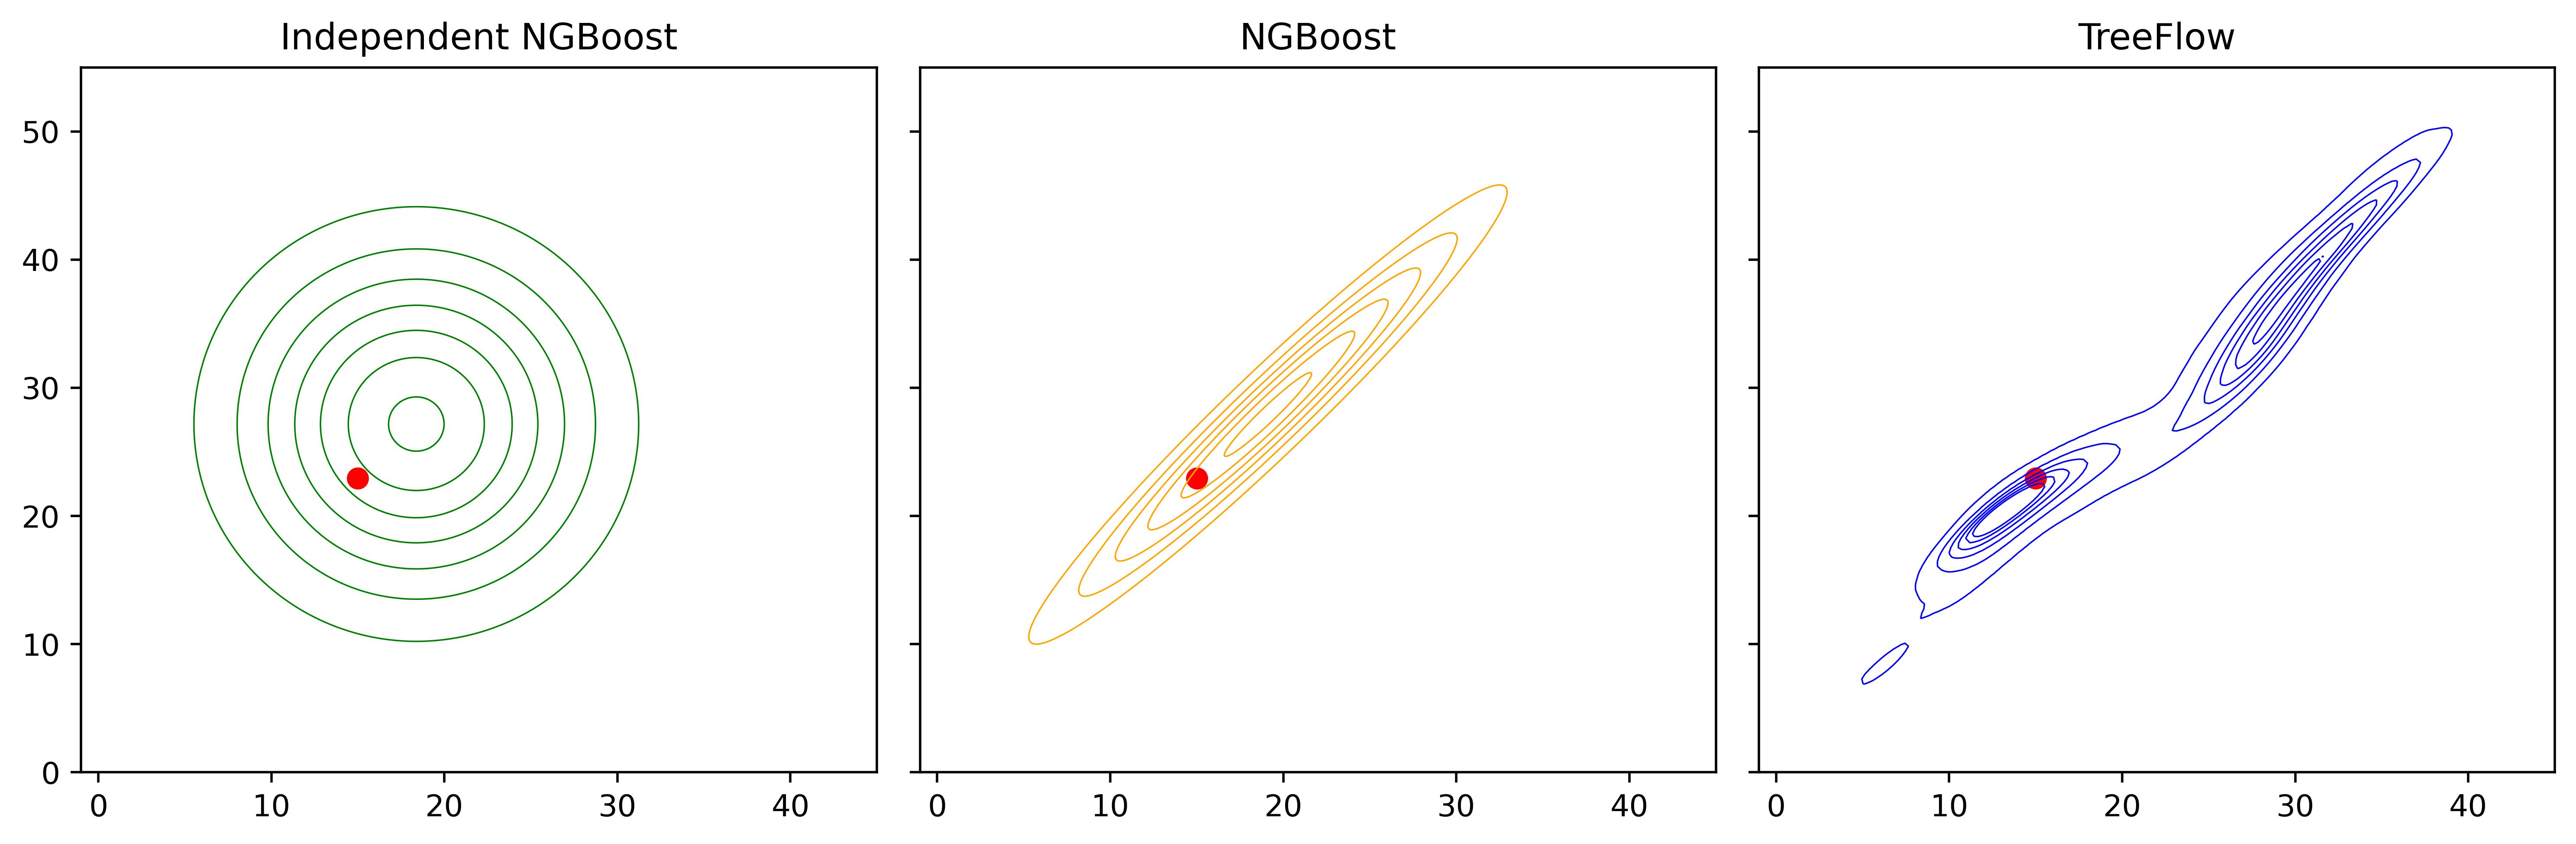

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True, sharex=True, dpi=500)
    
for index, i in enumerate([33]):
    x, y = np.mgrid[-1:45:0.1, 0:55:0.1]
    pos = np.dstack((x, y))
    
    samples_tfb = treeflow.sample(x_test.values[i:i+1, :], num_samples=100000)
    ngb_distribution = ngb.pred_dist(x_test.values[i:i+1, :]).scipy_distribution()[0]
    ngb_indep_distribution = ngb_indep.scipy_distribution(x_test.values[i:i+1, :])[0]
    
    ax[0].contour(x, y, ngb_indep_distribution.pdf(pos), linewidths = 0.5, levels = 7, colors = 'green')
    ax[0].scatter(y_test.values[i, 0], y_test.values[i, 1], color = 'red', s = 40)
    ax[0].set_title('Independent NGBoost')
    
    ax[1].contour(x, y, ngb_distribution.pdf(pos), linewidths = 0.5, levels = 7, colors = 'orange')
    ax[1].scatter(y_test.values[i, 0], y_test.values[i, 1], color = 'red', s = 40)
    ax[1].set_title('NGBoost')
    
    sns.kdeplot(x=samples_tfb[0, :, 0], y=samples_tfb[0, :, 1], linewidths = 0.5, levels = 7, color = 'blue', label = 'TreeFlow', ax=ax[2])
    ax[2].scatter(y_test.values[i, 0], y_test.values[i, 1], color = 'red', s = 40)
    ax[2].set_title('TreeFlow')

plt.xlim([-1, 45])
plt.ylim([0, 55])
plt.tight_layout()
plt.savefig('parkinsons.pdf')